# Performance Increase Testing for fsubk(t0)

In [1]:
import timeit 

### A few things to point out here
 1. timeit.timeit("",number=x) has 2 parameters. A string where you pass in a block of code to run and the number of times to run. The output is the number of seconds it take to execute.
 
 2. The number of times a program runs varies depending on the memory used (like within lists), the firepower of your computer (RAM,OS,etc), the number of tabs you have open, the brightness of your screen, etc. Best to pass in a large number x, and then take the average. Here I do number = 3 but truth be told, it doesn't vary that much.
 
 3. timeit hates when you pass in something like: from module import *, so best to be explicit.
 
 4. Since comments don't contribute anything, best to leave 'em out in the timeit.timeit string.
 
 5. Built-in functions are significantly faster than functions used by modules. For example, take a look at this: 



In [41]:
timeit.timeit('''
import sympy as sym
float(sym.sqrt(2))
''',number=100000)

3.747902962990338

In [42]:
timeit.timeit('''
float(2**(1/2))
''',number=100000)

0.024167358002159745

2**(1/2) is builtin whereas sym.sqrt(2) is not and as a result takes an eternity longer. However, both end up calculating the same thing

 6. Variables locally defined inside a function are faster than global variables (variables outside the function). In general, globals cause errors so best to avoid them.
 
 7. for loops with appending stuff to lists take soooo much time. Best to use the builtin map function.
 
 8. if/else statements also take soooo much time. Best to use the builtin functions filter and map.
 
 9. np.sum(any_list) is slower than sum(any_list). Both take the sum of the elements in a list, but sum is builtin whereas np.sum is not.
 
 10. If you declare a list as a variable, then every time the function is called, a new list replaces the existing one. This avoids the somelist.clear()
 
 11. nsum ate up so much time (~36 seconds). Then I realized it was a geometric series in disguise, so setting the variable const equal to the explict value for it, saved me a whopping 35 seconds! This makes sense considering I don't have to tell python work hard on approximating the infinite sum when I could just put in the analytic value
 
 12. List comprehensions will work faster than map if lists are big
 

### This is the original function

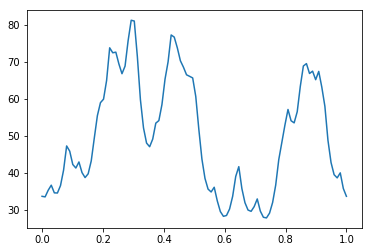

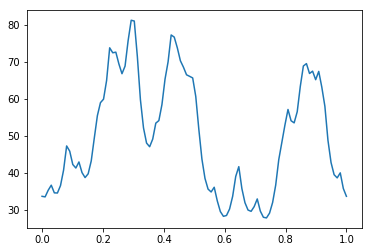

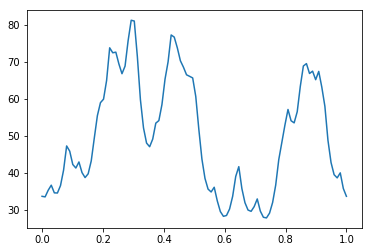

329.9485300959932

In [43]:
timeit.timeit('''
import numpy as np 
import mpmath
import sympy as sym
import matplotlib.pyplot as plt
np.random.seed(100000) 

ulist = np.random.uniform(size=40)

sigma = 0.05 

somelist = [] 

def fsubk(t0): 
    somelist.clear() 
    for i in range(0,len(ulist)): 
        somelist.append(float(sym.exp((ulist[i]-t0)/(sigma/sym.sqrt(2)))*mpmath.nsum(lambda k: sym.exp(-k/(sigma/sym.sqrt(2))),[1,mpmath.inf]))) 
        somelist.append(float(sym.exp((t0-ulist[i])/(sigma/sym.sqrt(2)))*mpmath.nsum(lambda k: sym.exp(k/(sigma/sym.sqrt(2))),[-mpmath.inf,-1]))) 
        if t0 >= ulist[i]: # this is the for loop for the conditional term 
            somelist.append(float(sym.exp((ulist[i]-t0)/(sigma/sym.sqrt(2))))) 
        else:
            somelist.append(float(sym.exp((t0-ulist[i])/(sigma/sym.sqrt(2))))) 
    return float(np.sum(somelist)*(1/(sigma*sym.sqrt(2)))+10)

vfunc = np.vectorize(fsubk) 
x = np.linspace(0,0.9999999999999,100) 
y = vfunc(x) 
plt.plot(x,y)
plt.show() 
''',number=3)

In [44]:
329.9485300959932/3 # compute the mean

109.98284336533106

So it takes ~110 seconds to complete 1 graph w/out optimization!

In [67]:
float(((110*100)/60)/60) # how much **hours**

3.055555555555556

That's ~3 hours 3 mins to complete 100 graphs! How long!

### Optimization 1 
Here I get rid of the for loop and if/else statement entirely and replace it with the map and filter functions (clause 7 and 8). A and B have map because those are the (unconditional) term 1 and term 2, so I can map the function directly from ulist. However, the if/else statement require filtering ulist so that's where c1 and c2 come from. Finally, I have to apply the respective functions on c1 and c2 and that's where map comes in and C1 and C2. I put sigma inside (clause 6) and set the lists to variables (clause 10). Also, I replace np.sum with sum (clause 9 and 5) and replace sym.sqrt(2) with (2**(1/2)) (clause 5).

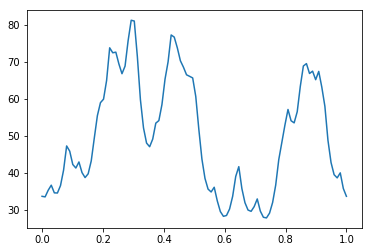

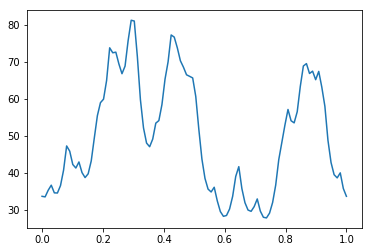

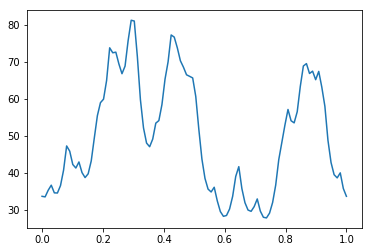

214.7257529710041

In [21]:
timeit.timeit('''
import numpy as np 
import mpmath
import sympy as sym
import matplotlib.pyplot as plt
np.random.seed(100000)

ulist = np.random.uniform(size=40)

def fsubk(t0): 
    sigma = 0.05
    const = float(mpmath.nsum(lambda k: sym.exp(-k/(sigma/sym.sqrt(2))),[1,mpmath.inf]))
    A = list(map(lambda u: float(sym.exp((u-t0)/(sigma/(2**(1/2)))*const),ulist)))
    B = list(map(lambda u: float(sym.exp((t0-u)/(sigma/(2**(1/2)))*const),ulist)))
    c1 = list(filter(lambda u: t0>=u,ulist)) 
    c2 = list(filter(lambda u: t0<u,ulist))
    C1 = list(map(lambda u: float(sym.exp((u-t0)/(sigma/sym.sqrt(2)))),c1))
    C2 = list(map(lambda u: float(sym.exp((t0-u)/(sigma/sym.sqrt(2)))),c2))
    return float(((sum(A)+sum(B)+sum(C1)+sum(C2))*(1/(sigma*sym.sqrt(2))))+10)

vfunc = np.vectorize(fsubk) 
x = np.linspace(0,0.9999999999999,100) 
y = vfunc(x) 
plt.plot(x,y)
plt.show() 
''',number=3)

In [24]:
215/3 # compute the mean

71.66666666666667

Now it takes ~71.7 seconds to complete 1 graph. A huge improvement (~38.3 seconds faster), but still not satisfactory. 

### Optimization 2

So at this point, I believe I did everything possible, but nsum looked very fishy. Turns out it is a geometric series in disguise (clause 11):

In [52]:
%%latex
$$\sum_{n\geq1}x^{-n/c}=\sum_{n\geq1}\left(\frac{1}{\sqrt[c]{x}}\right)^n = \frac{1}{\sqrt[c]{x}-1}$$

<IPython.core.display.Latex object>

Series we're working with:

In [64]:
%%latex
$$\overbrace{\sum_{k<-1}\exp\left(\frac{k}{(\sigma/\sqrt{2})}\right)=\sum_{k\geq1}\exp\left(-\frac{k}{(\sigma/\sqrt{2})}\right)}^{\textrm{first equality}}=\sum_{k\geq1}\left(\frac{1}{e^{(\sqrt{2}/\sigma)}}\right)^k=\frac{1}{e^{(\sqrt{2}/\sigma)}-1}=\textrm{const}$$

<IPython.core.display.Latex object>

I forgot to mention that nsum was once used twice. If you notice, they're equal by symmetry, which is why the first equality is satisfied.  

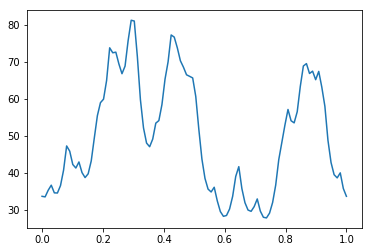

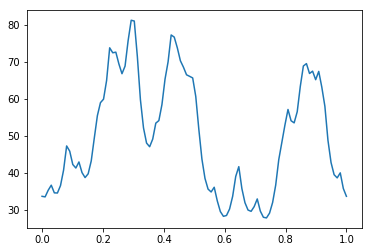

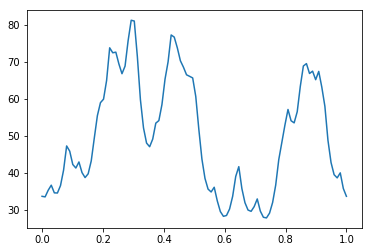

7.240149157999895

In [17]:
timeit.timeit('''
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(100000)

ulist = np.random.uniform(size=40)

def fsubk(t0): 
    sigma = 0.05
    const = float(1/(sym.exp((2**(1/2))/sigma)-1))
    a = list(map(lambda u: float(sym.exp((u-t0)/(sigma/(2**(1/2))))*const),ulist))
    b = list(map(lambda u: float(sym.exp((t0-u)/(sigma/(2**(1/2))))*const),ulist))
    c1 = list(filter(lambda u: t0>=u,ulist)) 
    c2 = list(filter(lambda u: t0<u,ulist))
    C1 = list(map(lambda u: float(sym.exp((u-t0)/(sigma/(2**(1/2))))),c1))
    C2 = list(map(lambda u: float(sym.exp((t0-u)/(sigma/(2**(1/2))))),c2))
    return float(((sum(a)+sum(b)+sum(C1)+sum(C2))*(1/(sigma*(2**(1/2)))))+10)

vfunc = np.vectorize(fsubk) 
x = np.linspace(0,0.9999999999999,100) 
y = vfunc(x) 
plt.plot(x,y)
plt.show() 
''',number=3)

In [38]:
7.926714643006562/3 # compute the mean

2.6422382143355208

Wow would you look at that! Now it takes ~2.65 seconds to complete 1 graph

### Optimization 3
At this point I could have stopped, but was like: I have one more trick under my belt (clause 12) to make this run faster (although marginally). So I remove the filter functions and replace them with list comprehension for c1 and c2

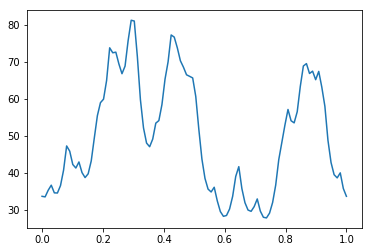

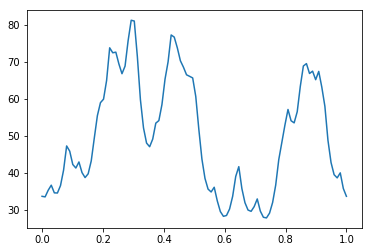

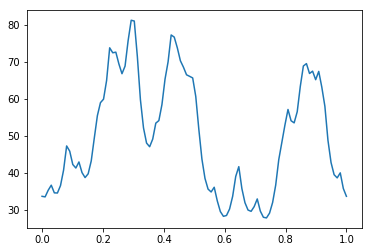

7.663272434000646

In [3]:
timeit.timeit('''
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(100000)

ulist = np.random.uniform(size=40)

def fsubk(t0): 
    sigma = 0.05
    const = float(1/(sym.exp((2**(1/2))/sigma)-1))
    a = list(map(lambda u: float(sym.exp((u-t0)/(sigma/(2**(1/2))))*const),ulist))
    b = list(map(lambda u: float(sym.exp((t0-u)/(sigma/(2**(1/2))))*const),ulist))
    c1 = [u for u in ulist if t0>=u]
    c2 = [u for u in ulist if t0<u]
    C1 = list(map(lambda u: float(sym.exp((u-t0)/(sigma/(2**(1/2))))),c1))
    C2 = list(map(lambda u: float(sym.exp((t0-u)/(sigma/(2**(1/2))))),c2))
    return float(((sum(a)+sum(b)+sum(C1)+sum(C2))*(1/(sigma*(2**(1/2)))))+10)

vfunc = np.vectorize(fsubk) 
x = np.linspace(0,0.9999999999999,100) 
y = vfunc(x) 
plt.plot(x,y)
plt.show() 
''',number=3)

In [40]:
7.336410104995593/3 # compute the mean

2.445470034998531

This is my best: ~ 2.45 seconds to complete 1 graph. 0.12 second improvement from the former. This is a 97.8% increase in performance from what we had in the beginning!!! Instead of 3 hours and 3 mins, generating 100 graphs will take us: 

In [69]:
(2.45*100)/60 # how much **minutes**

4.083333333333334

about 4 minutes!

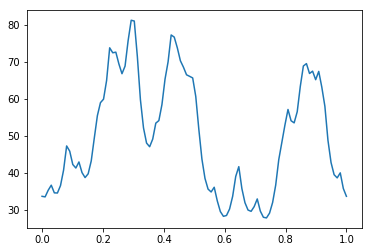

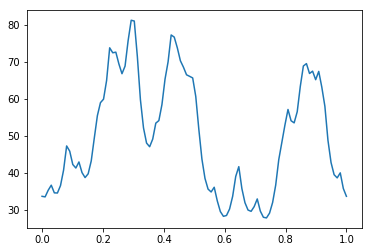

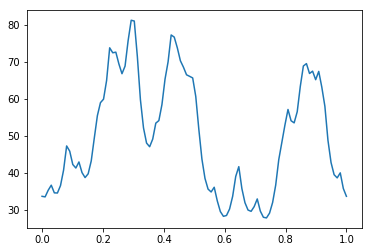

7.475561452999955

In [4]:
timeit.timeit('''
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(100000)

ulist = np.random.uniform(size=40)

def fsubk(t0): 
    sigma = 0.05
    const = float(1/(sym.exp((2**(1/2))/sigma)-1))
    a = sum(map(lambda u: float(sym.exp((u-t0)/(sigma/(2**(1/2))))*const),ulist))
    b = sum(map(lambda u: float(sym.exp((t0-u)/(sigma/(2**(1/2))))*const),ulist))
    c1 = [u for u in ulist if t0>=u]
    c2 = [u for u in ulist if t0<u]
    C1 = sum(map(lambda u: float(sym.exp((u-t0)/(sigma/(2**(1/2))))),c1))
    C2 = sum(map(lambda u: float(sym.exp((t0-u)/(sigma/(2**(1/2))))),c2))
    return float(((a+b+C1+C2)*(1/(sigma*(2**(1/2)))))+10)

vfunc = np.vectorize(fsubk) 
x = np.linspace(0,0.9999999999999,100) 
y = vfunc(x) 
plt.plot(x,y)
plt.show() 
''',number=3)

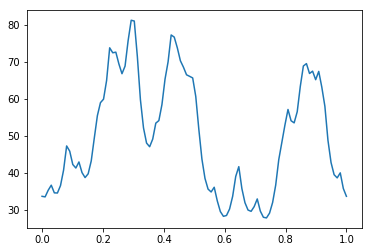

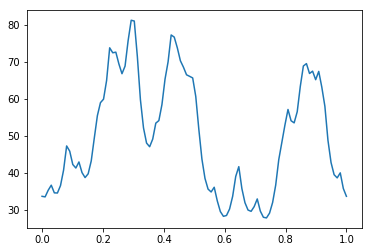

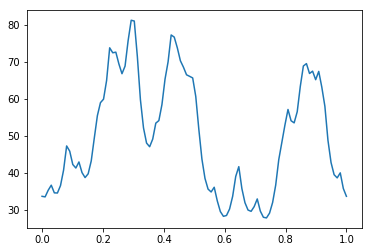

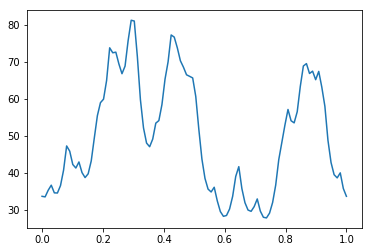

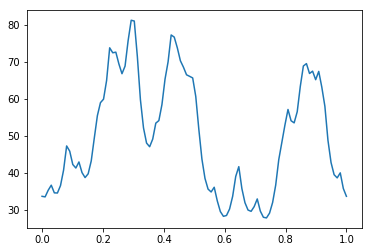

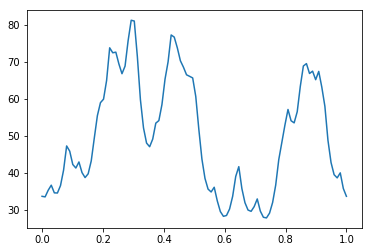

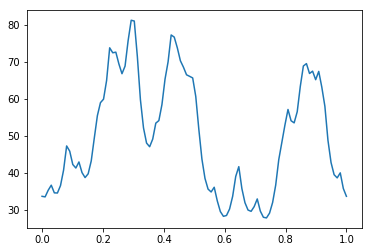

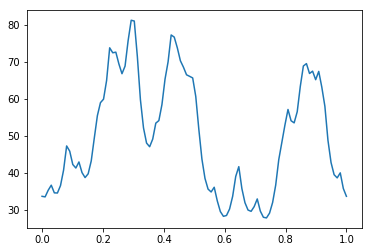

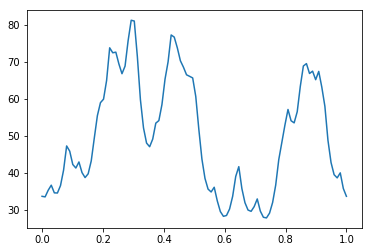

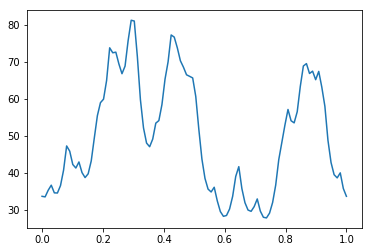

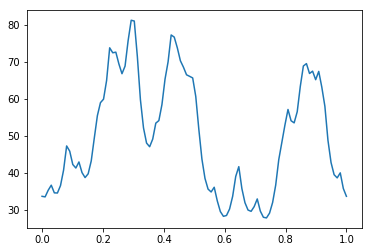

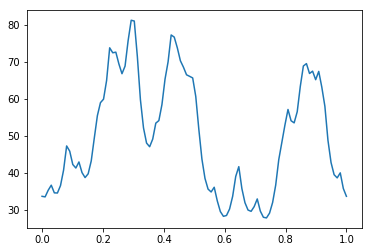

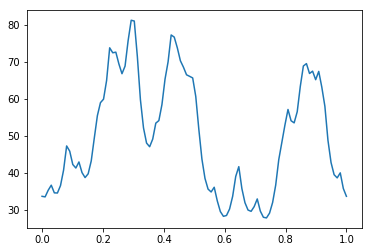

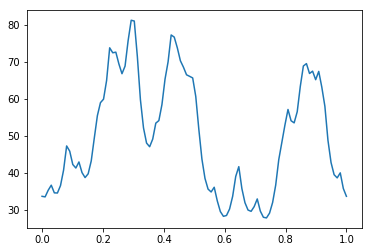

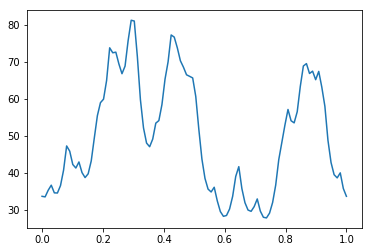

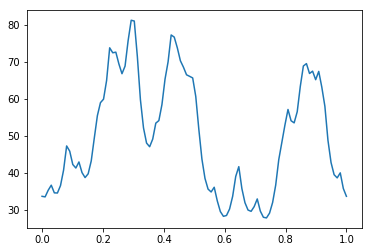

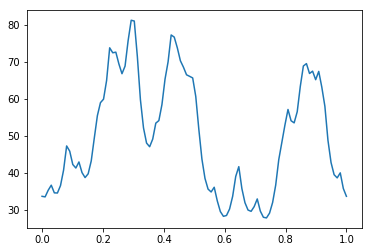

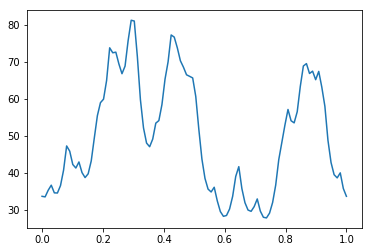

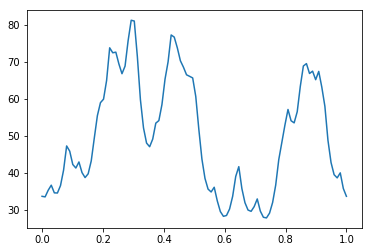

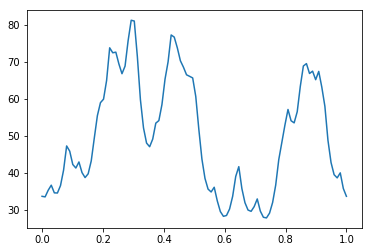

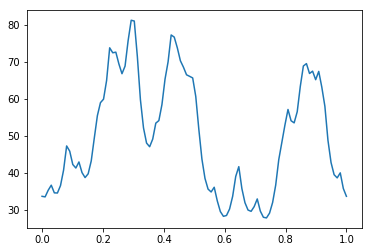

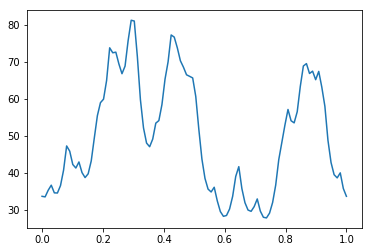

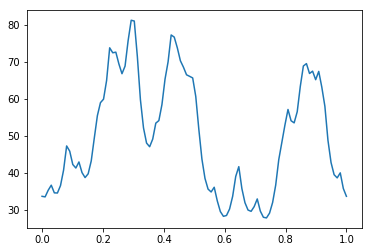

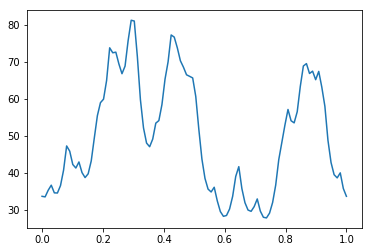

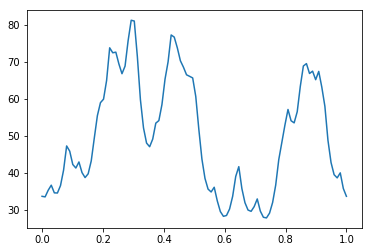

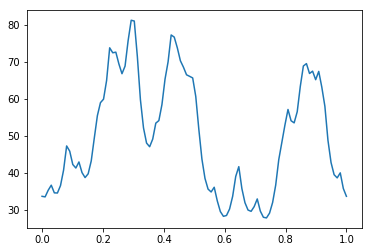

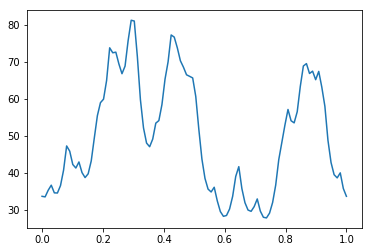

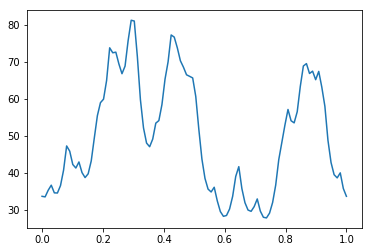

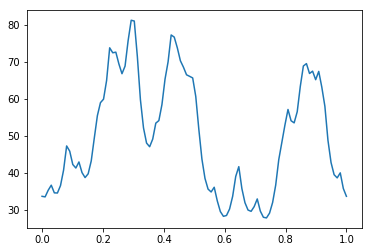

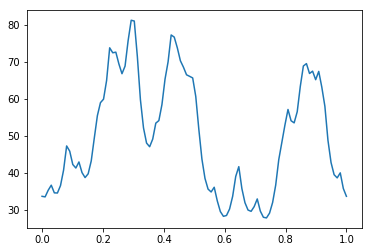

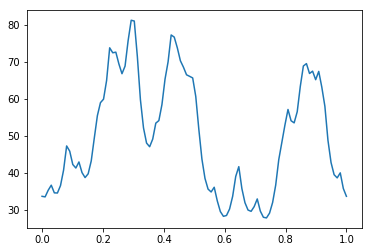

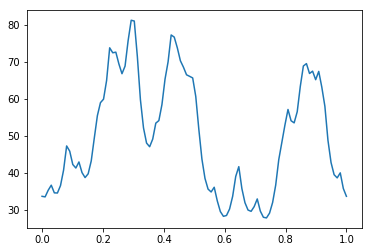

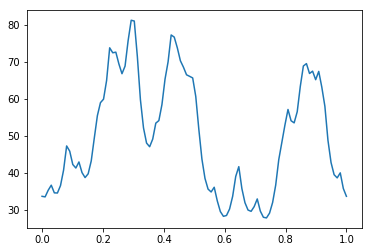

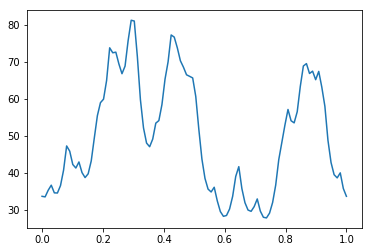

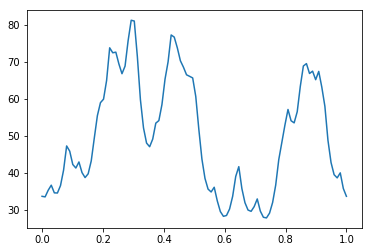

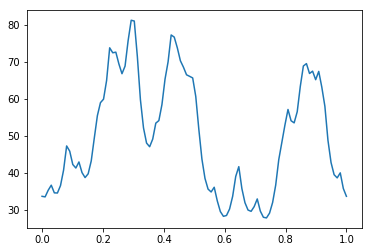

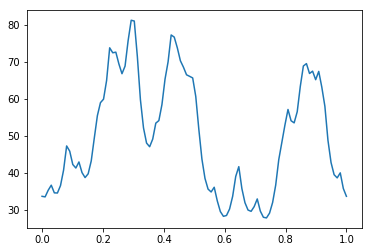

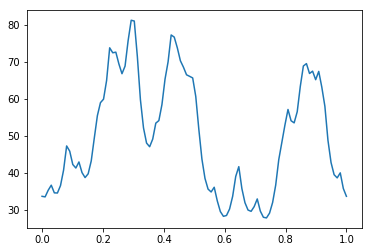

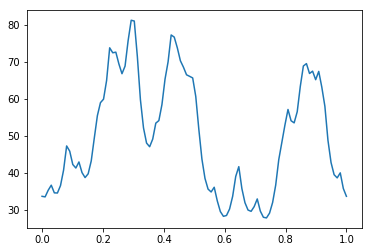

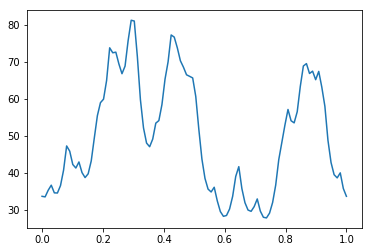

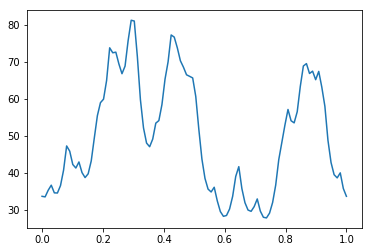

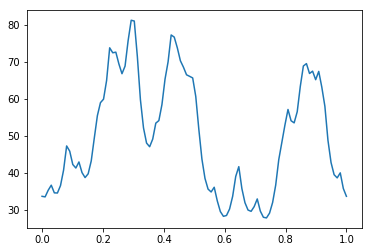

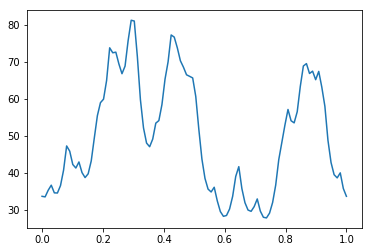

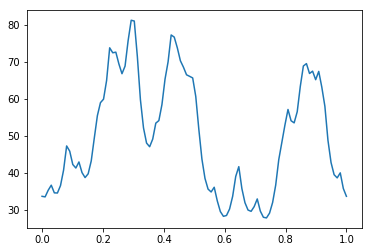

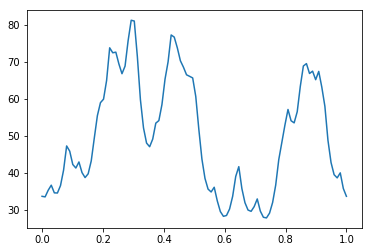

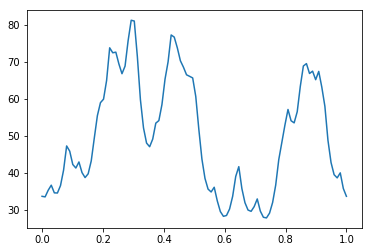

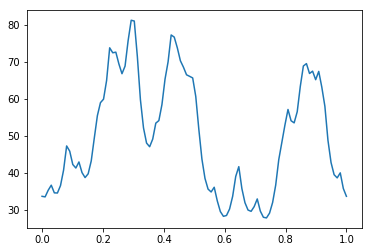

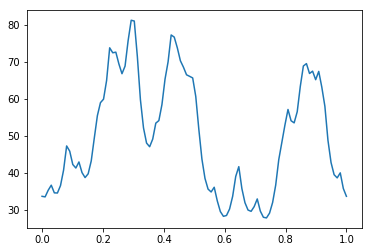

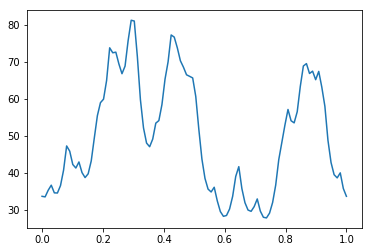

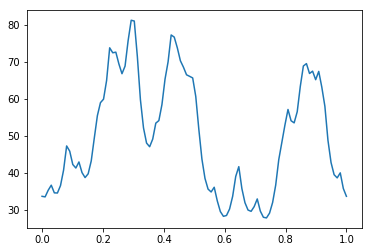

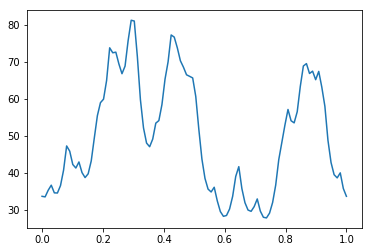

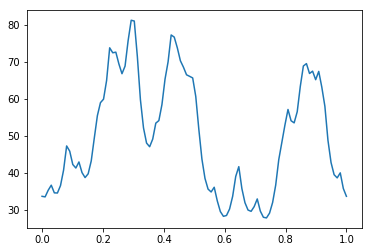

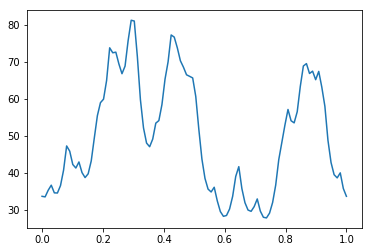

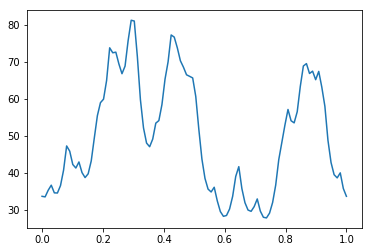

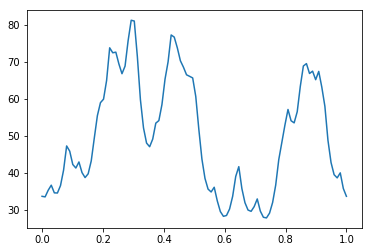

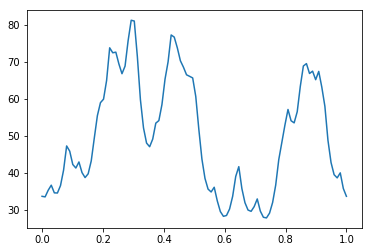

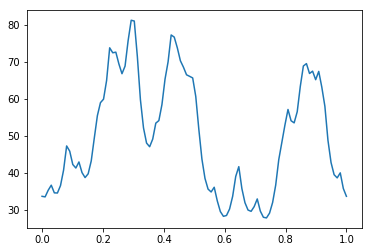

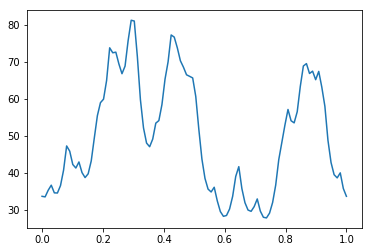

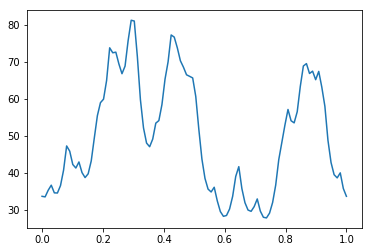

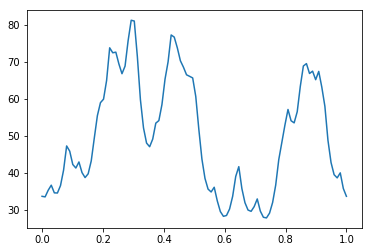

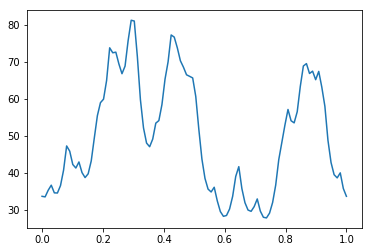

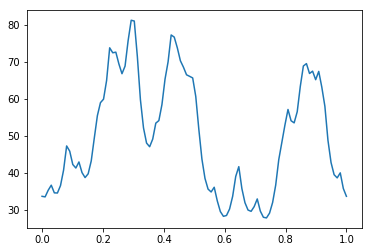

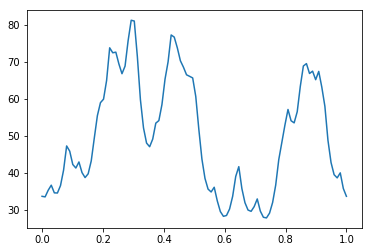

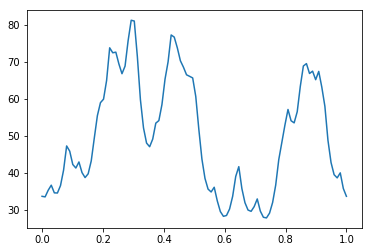

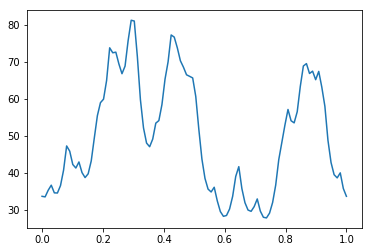

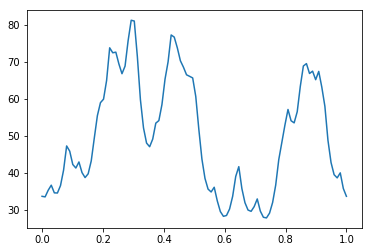

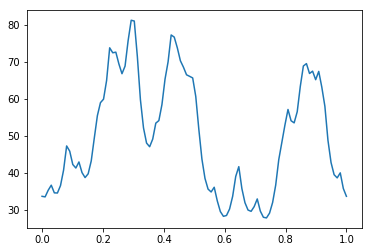

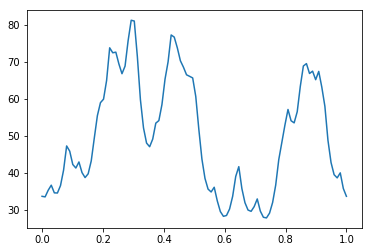

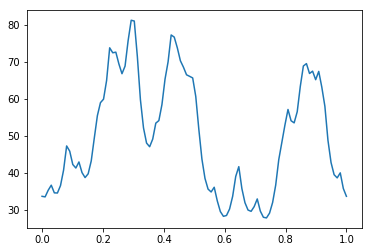

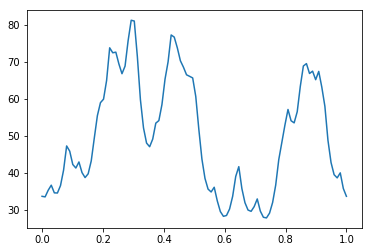

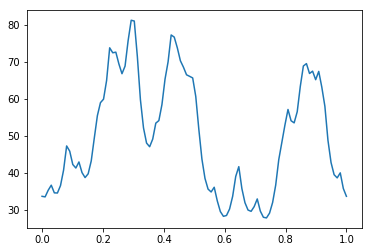

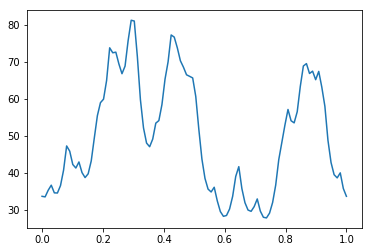

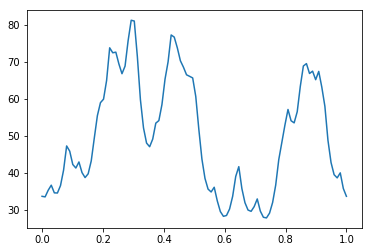

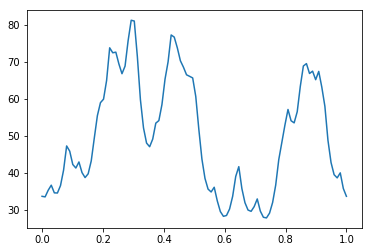

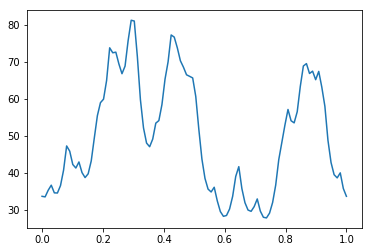

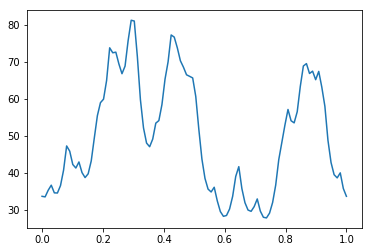

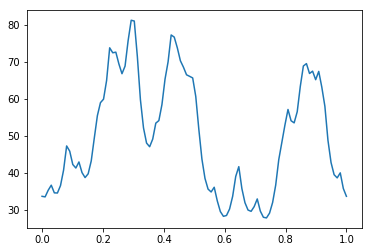

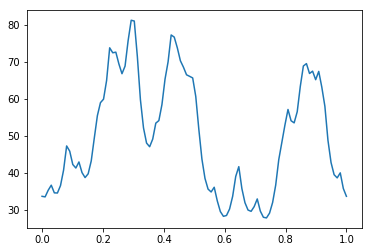

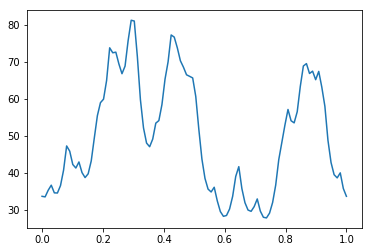

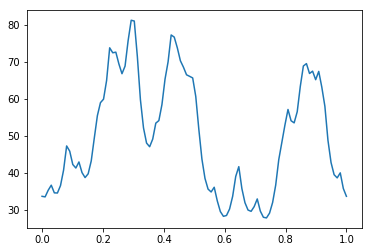

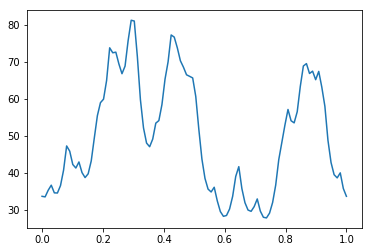

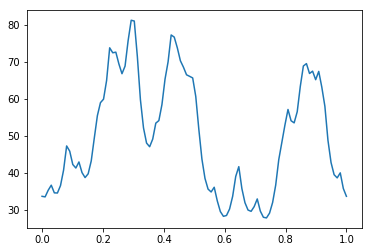

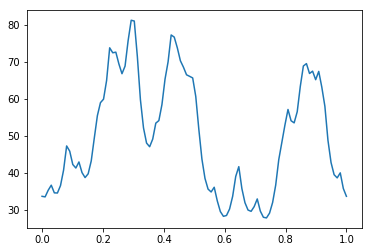

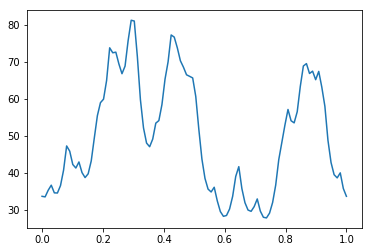

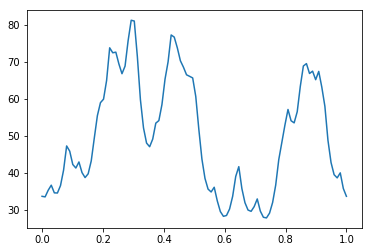

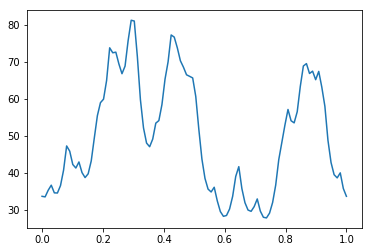

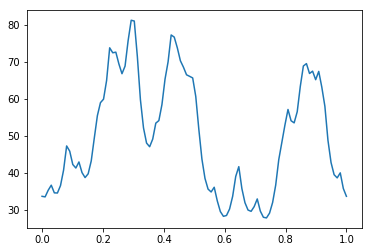

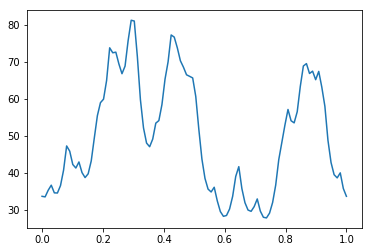

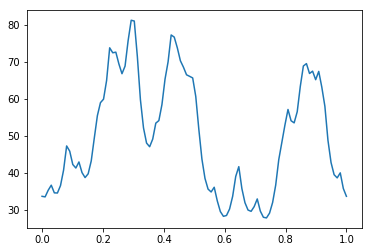

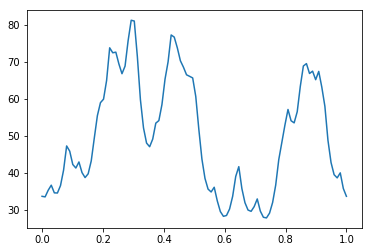

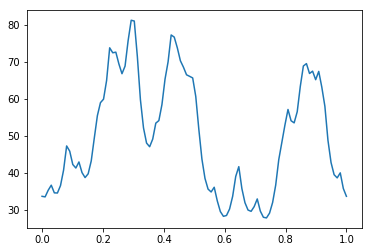

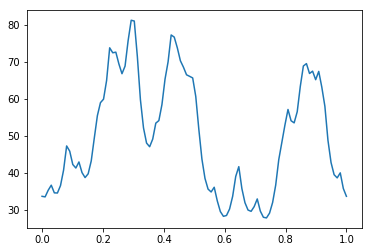

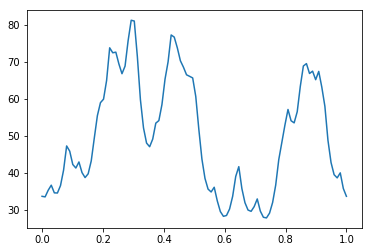

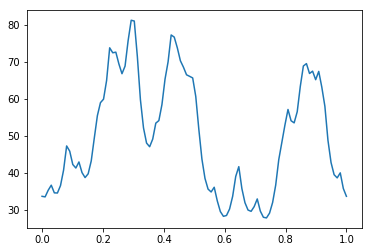

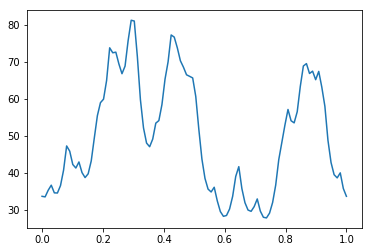

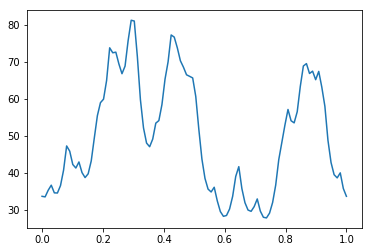

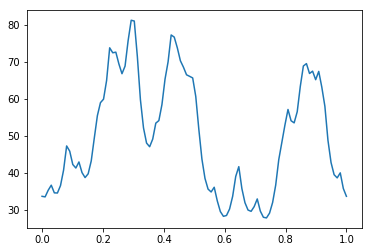

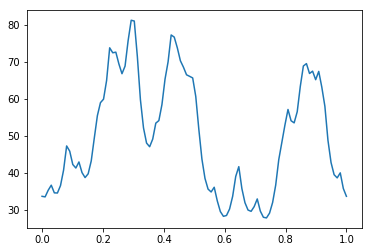

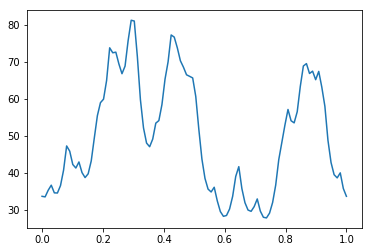

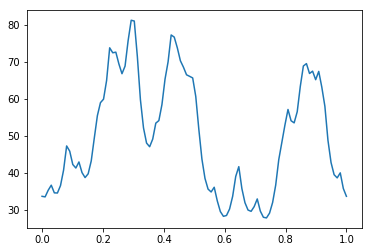

15.377920621000158

In [4]:
timeit.timeit('''
import math as m
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(100000)

ulist = np.random.uniform(size=40)

def fsubk(t0): 
    sigma = 0.05
    const = float(1/(m.exp((2**(1/2))/sigma)-1))
    a = sum(map(lambda u: float(m.exp((u-t0)/(sigma/(2**(1/2))))*const),ulist))
    b = sum(map(lambda u: float(m.exp((t0-u)/(sigma/(2**(1/2))))*const),ulist))
    c1 = [u for u in ulist if t0>=u]
    c2 = [u for u in ulist if t0<u]
    C1 = sum(map(lambda u: float(m.exp((u-t0)/(sigma/(2**(1/2))))),c1))
    C2 = sum(map(lambda u: float(m.exp((t0-u)/(sigma/(2**(1/2))))),c2))
    return float(((a+b+C1+C2)*(1/(sigma*(2**(1/2)))))+10)

vfunc = np.vectorize(fsubk) 
x = np.linspace(0,0.9999999999999,100) 
y = vfunc(x) 
plt.plot(x,y)
plt.show() 
''',number=100)

In [6]:
15.232774243000677/100

0.15232774243000677

In [7]:
((110-0.15232774243000677)/110)*100

99.86152023415454

In [2]:
from time import time
from itertools import product
import numpy as np

In [30]:
x = np.random.uniform(size=1000)
y = np.random.uniform(size=1000)

In [38]:
start = time()
np.asarray(list(product(x,y)))
end = time()
end-start

0.49785304069519043

In [39]:
start = time()
np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
end = time()
end-start

0.03153586387634277

In [50]:
s = [1,1,1,0,0,0]
(filter(None,s)

NameError: name 'yeild' is not defined